In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import geopandas as gpd
import re
import os
import nltk
import gensim
import string
import time
#import random
from mpl_toolkits import mplot3d
from gensim import corpora
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from shapely.geometry import Point, Polygon, LineString
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.basemap import Basemap

#random.seed(123)

In [6]:
messages = pd.read_csv('CleanedData.csv',index_col=0)
geoMessages = gpd.GeoDataFrame(messages)

In [7]:
geometryList = []
for i,(shape,geom) in enumerate(zip(geoMessages.GeometryType,geoMessages.Coordinates)):
    
    if shape == 'Point':
        coor = []
        ele = geom.split()
        ele = [float(re.sub('[](),[]','',i)) for i in ele]

        coor.append(tuple(ele))
        geo = Point(coor)
        geometryList.append(geo)
        
    elif shape == 'GeometryCollection':
        
        coor = []
        ele = geom.split()
        ele = [float(re.sub('[](),[]','',i)) for i in ele]
        
        tupleCoor = [tuple(ele[i:i+3]) for i in np.arange(0,len(ele),3)]
        if i == 4956 or i == 5681 or i == 1037:
            # Necessary because the two observations are LineStrings, or closer to linestrings than polygons.
            geo = LineString(tupleCoor)
        else:
            geo = Polygon(tupleCoor)
        geometryList.append(geo)

In [8]:
worldSeas = gpd.read_file('World_Seas_IHO_v3/World_Seas_IHO_v3.shp')

In [9]:
# Storing the geometries in something we can work with.
geometryFrame = gpd.GeoDataFrame(geometry=geometryList)

# Storing the centroids
geometryFrame['Centroids']=geometryFrame.centroid
geometryFrame['CentroidCoor'] = [list(geometryFrame['Centroids'].loc[obs].coords)[0] for obs in geometryFrame.index]

# Creating a reduced dataframe based on the unique coordinates
reducedCentroidCoordinates = geometryFrame.drop_duplicates(subset=['CentroidCoor'])

# Creating the reduced geometry dataframe
reducedGeometryFrame = geometryFrame.loc[reducedCentroidCoordinates.index]
reducedGeometryFrame = reducedGeometryFrame.reset_index(drop=True)

reducedMessages = messages.loc[reducedCentroidCoordinates.index]
reducedMessages = reducedMessages.reset_index()
# Setting the type of the date columns correctly
reducedMessages['StartDate'] = reducedMessages['StartDate'].astype('datetime64[ns]')
reducedMessages['EndDate'] = reducedMessages['EndDate'].astype('datetime64[ns]')
# Calculating the duration
reducedMessages['Duration'] = reducedMessages['EndDate']-reducedMessages['StartDate']
# Setting the geometry of the reduced-messages-dataframe
reducedGeoMessages = geoMessages.loc[reducedCentroidCoordinates.index]
reducedGeoMessages = reducedGeoMessages.reset_index(drop=True)
reducedGeoMessages['geometry'] = reducedGeometryFrame['geometry']
reducedGeoMessages['Centroids'] = reducedGeometryFrame['Centroids']
reducedGeoMessages['CentroidCoor_X'] = [list(reducedGeoMessages['Centroids'].loc[obs].coords)[0][0] for obs in reducedGeoMessages.index]
reducedGeoMessages['CentroidCoor_Y'] = [list(reducedGeoMessages['Centroids'].loc[obs].coords)[0][1] for obs in reducedGeoMessages.index]
reducedGeoMessages['Duration'] = reducedMessages['EndDate']-reducedMessages['StartDate']
#reducedMessages['Duration'] = reducedMessages['Duration'].astype('int')
reducedGeoMessages.geometry = reducedGeoMessages['geometry']
reducedGeoMessages.crs = worldSeas.crs


In [10]:
durationCount = {}
for obs in reducedMessages.Duration:
    if obs.days in durationCount.keys():
        durationCount[obs.days] += 1
    else:
        durationCount[obs.days] = 1

In [11]:
sortedDurationCount = sorted(durationCount.items(), key = lambda kv: kv[0],reverse = False)
sortedDurationCount[0:10]

[(-18, 1),
 (0, 1870),
 (1, 264),
 (2, 172),
 (3, 119),
 (4, 83),
 (5, 88),
 (6, 46),
 (7, 39),
 (8, 45)]

In [12]:
durationDays = []
daysCount = []

for obs in sortedDurationCount:
    if obs[0]>=0:
        durationDays.append(obs[0])

        daysCount.append(obs[1])

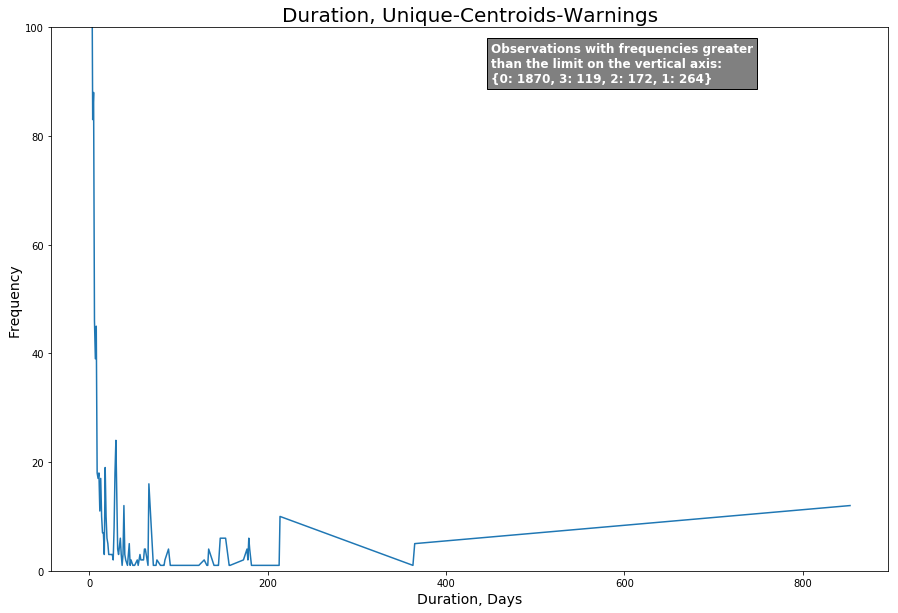

In [13]:
ylim = 100

plt.figure(figsize=(15,10))
plt.plot(durationDays,daysCount)
plt.title('Duration, Unique-Centroids-Warnings',size= 20)
plt.xlabel('Duration, Days',size = 14)
plt.ylabel('Frequency',size = 14)
plt.ylim(0,ylim)
excluded={i:e for i,e in durationCount.items() if e > ylim}
textstr = '\n'.join((
    'Observations with frequencies greater',
    'than the limit on the vertical axis:',
    str(excluded)))

plt.text(450, 90, textstr,bbox=dict(facecolor='grey',alpha=1),
        color='w',size=12,fontweight ='bold')

plt.show()

In [14]:
days = reducedGeoMessages.Duration.dt.days
uniqueDays = days.unique()
np.array(sorted(uniqueDays))
absDays = abs(days)

From here on, it is decided to work with the absolute duration, as the actual start of message as such shouldn't matter - duration is duration.

In [15]:
# Calculate the number of duplicates in the entire dataset
numOfDuplicates = [sum(geometryFrame.CentroidCoor==reducedGeometryFrame.CentroidCoor.loc[i]) for i in np.arange(reducedGeometryFrame.shape[0])]
numOfDuplicates=np.array(numOfDuplicates)

(array([2.387e+03, 1.600e+02, 8.200e+01, 2.040e+02, 2.830e+02, 1.000e+01,
        1.000e+00, 5.000e+00, 1.000e+00, 2.000e+00]),
 array([  1. ,  17.1,  33.2,  49.3,  65.4,  81.5,  97.6, 113.7, 129.8,
        145.9, 162. ]),
 <a list of 10 Patch objects>)

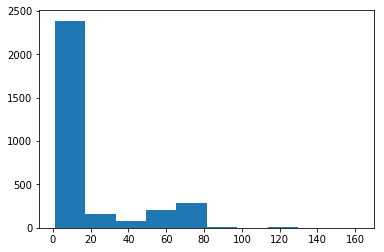

In [16]:
# Extracting the unique number of duplicates and visualisng the distribution of the duplicates
uniqueDuplicates = pd.unique(numOfDuplicates)
plt.hist(numOfDuplicates)

In [17]:
# Let see some stats.
# First the unique values
uniqueDuplicates = np.array(sorted(uniqueDuplicates))
print('The unique number of duplicates are:\n\n',uniqueDuplicates)
# Then the number of unique valus
print('\nThere are in total %i number of duplicates' % len(uniqueDuplicates))
# Finally, the frequency of the unique values
frequencyUniqueDuplicates = np.array([sum(numOfDuplicates==i) for i in np.array(sorted(uniqueDuplicates))])
print('\nThe frequency of each of the duplicates are:\n\n',frequencyUniqueDuplicates)

The unique number of duplicates are:

 [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  66  67  68  69  70  71  72  73
  74  75  76  77  78  83  86  87  88  91 103 118 120 123 135 152 162]

There are in total 89 number of duplicates

The frequency of each of the duplicates are:

 [795 286 241 181 152  80  51  52  87  90  65  79  60  77  36  21  34  18
   7  12  24   9  15  12   7   7   3  10  20   7   2   1   6   9   4   1
  10   1   8   5   3   2   2  18   4   3   4   5   3   5   1   7   1   4
   4   4   6  22 141   1   3   2   1   2   4   7   2   2   1   1   1   1
   1   3 252   7   1   3   1   3   1   2   1   1   1   3   1   1   1]


In [18]:
numbOfClasses = 4
treshold = len(numOfDuplicates)/numbOfClasses

classObservations = [[] for i in np.arange(numbOfClasses)]
j = 1
lowerbound = 0
classedObs = 0

for i,duplicate in enumerate(uniqueDuplicates):
    # Assignning the unique duplicate values to each class, and thereby the observations
    if (classedObs+frequencyUniqueDuplicates[i]>treshold*j):
        classObservations[(j-1)].append(duplicate)
        classedObs += frequencyUniqueDuplicates[i]
        
    elif (classedObs+frequencyUniqueDuplicates[i] > lowerbound) and (classedObs+frequencyUniqueDuplicates[i]<treshold*j):
        classObservations[(j-1)].append(duplicate)
        classedObs += frequencyUniqueDuplicates[i]
    # Updating if the treshold is exceeded
    if classedObs> treshold*j:
        
        lowerbound =treshold*j
        j += 1
        

In [19]:
duplicateClassLabelAlt = np.zeros(len(numOfDuplicates))
for i,group in enumerate(classObservations):
    for numbofdup in group:
        duplicateClassLabelAlt[numOfDuplicates==numbofdup] = i

In [20]:
# The number of observations in each category
[sum(duplicateClassLabelAlt==i) for i in sorted(pd.unique(duplicateClassLabelAlt).astype(int))]

[796, 860, 698, 781]

In [21]:
durationSpan = [[] for i in np.arange(numbOfClasses)]

for i,group in enumerate(classObservations):
    if len(group) < 2:
        durationSpan[i]=group
    else:
        durationSpan[i]=(min(group),max(group))

In [22]:
durationSpan

[[1], (2, 5), (6, 16), (17, 152)]

In [23]:
# Preparing to label the unique messages
stepsize = 50
classRange = np.arange(1,max(uniqueDuplicates),stepsize)
classRange = np.append(classRange,(max(classRange)+stepsize))
print('The class range is:\n\n',classRange)

The class range is:

 [  1  51 101 151 201]


In [24]:
# Initialising the classLabel variable
duplicateClassLabel = np.zeros(len(numOfDuplicates))
# Assigning the classLabel to each observation
for i in np.arange(len(classRange)-1):
    
    duplicateClassLabel[numOfDuplicates[(numOfDuplicates>=classRange[i]) & (numOfDuplicates<classRange[i+1])]] = i

# Printing some final stats, the frequency and ensuring that the number of labels match the number of observations
print('The frequency of each of the class labels are:\n\n',[sum(duplicateClassLabel==i) for i in pd.unique(duplicateClassLabel)])
print('\nThe total amount of observations with class labels are:',sum([sum(duplicateClassLabel==i) for i in pd.unique(duplicateClassLabel)]))
print('\nThe total amount of observations are:',reducedGeometryFrame.shape[0])

The frequency of each of the class labels are:

 [3096, 32, 5, 2]

The total amount of observations with class labels are: 3135

The total amount of observations are: 3135


In [25]:
# The number of colors should match the number of classes
colors = ['r','g','y','c']
colorLabel = [colors[int(i)] for i in duplicateClassLabel]
colorLabelAlt = [colors[int(i)] for i in duplicateClassLabelAlt]

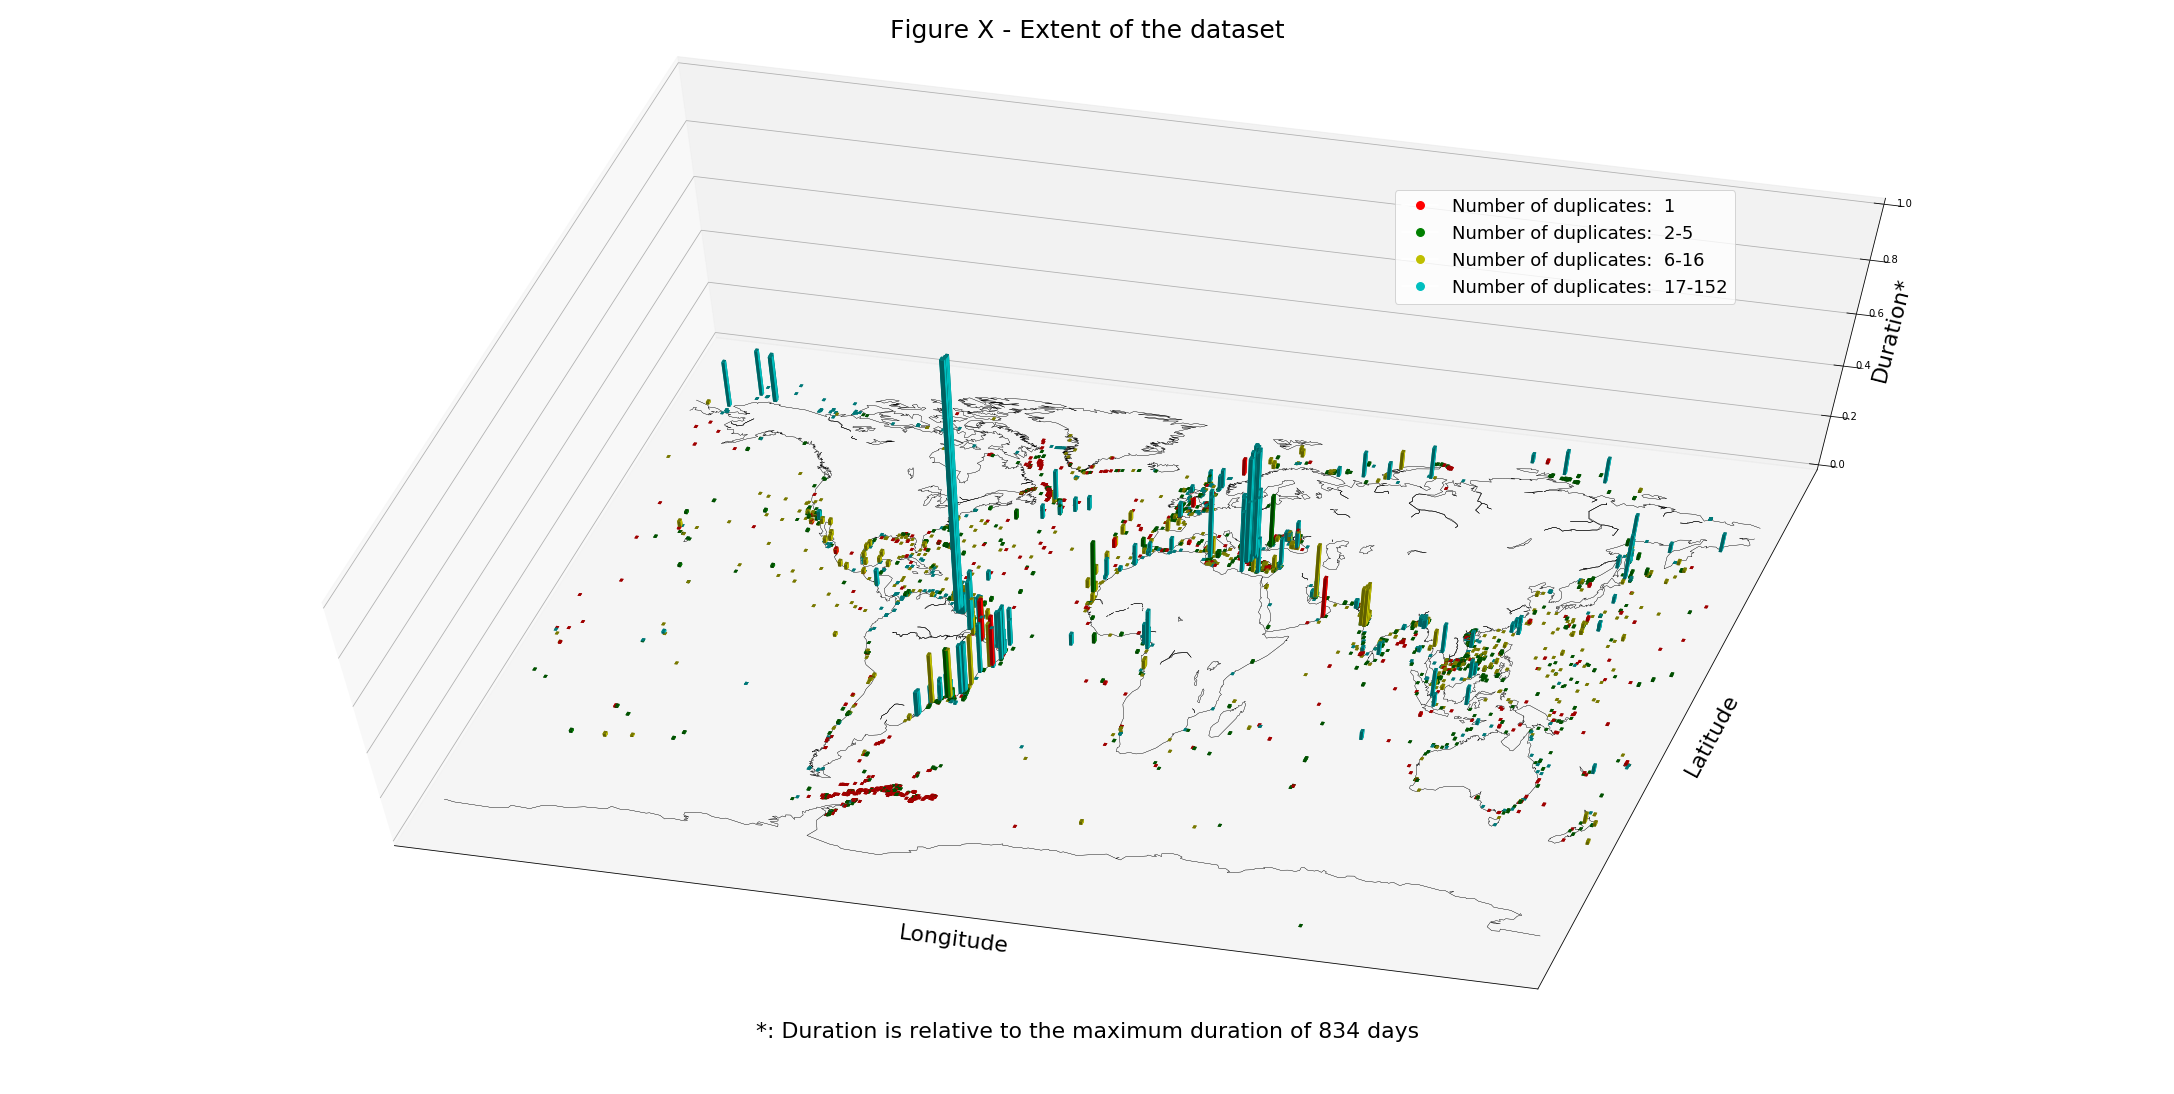

In [40]:
map = Basemap()

fig = plt.figure()#figsize=(30,30)
fig.set_size_inches(30,30)
ax = Axes3D(fig)

# Setting the variables
x = reducedGeoMessages.CentroidCoor_X
y = reducedGeoMessages.CentroidCoor_Y
z = np.zeros(len(reducedGeoMessages.CentroidCoor_X))

# Setting the size of the bar
# dx/dy is the size of the square on the bar
dx,dy = 1,1
# dz is the height of the bar
dz = absDays/max(absDays)

ax.add_collection3d(map.drawcoastlines(linewidth=0.25))
ax.bar3d(x,y,z,dx,dy,dz,color=colorLabelAlt)#,cmap=plt.colors.ListedColormap(colors)
ax.set_xlabel('Longitude',fontsize=22)
ax.set_ylabel('Latitude',fontsize=22)
ax.set_zlabel('Duration*',fontsize=22)
#ax.set_title('Figure X - Extent of the dataset',fontsize = 25)
ax.view_init(65,-75)

legend_elements = [Line2D([0], [0], marker='o', color='w',
                          label=('Number of duplicates:  '+ str(int(group[0]))),markerfacecolor=colors[int(i)],
                          markersize=10) if len(group) < 2 else Line2D([0], [0], marker='o', color='w',
                          label=('Number of duplicates:  '+ str(group[0])+'-'+str(group[1])),markerfacecolor=colors[int(i)],
                          markersize=10) for i,group in enumerate(durationSpan)]

#fig.suptitle('hej',fontsize=25)
plt.legend(handles=legend_elements,bbox_to_anchor=(0.8, 0.83), loc=1, borderaxespad=0.,prop={"size":18})

plt.subplots_adjust(top = 0.01, bottom = 0, right = 0.01, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0,0)
plt.title('Figure X - Extent of the dataset',fontsize = 25,y=1.05)
plt.suptitle('*: Duration is relative to the maximum duration of 834 days',fontsize = 22,y=0.28)
plt.savefig('observations.png', bbox_inches = 'tight',pad_inches = 0,dpi = 100)
#plt.show()